# NVIDIA Info

In [0]:
!nvidia-smi

Sat Feb 29 17:57:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Pip installs

In [0]:
'''
!pip install pillow
!pip install lxml
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install gdown
!pip install tensorflow-gpu
!pip install keras
'''

# Packages

## Other packages

In [0]:
import cv2
import numpy as np
import os
import random
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import matplotlib.image as img
%matplotlib inline
import matplotlib.pyplot as plt

## Tensorflow and Keras Packages

In [63]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

print("TensorFlow Version: {}".format(tf.__version__))
print("GPU: {}".format(tf.test.gpu_device_name()))

TensorFlow Version: 2.1.0
GPU: /device:GPU:0


# Download data and extract it

In [0]:
def dataExtraction():
  if 'food-101' in os.listdir():
    print('Dataset already exists')
  else:
    print('Downloading data ...')
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print('Data downloaded')
    print('...\nBeggining extraction ...')
    !tar xzvf food-101.tar.gz
    print('Extraction complete')

Getting the data

In [4]:
dataExtraction()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/3452001.jpg
food-101/images/cannoli/

# Analyse the data

What's inside:
*  This dataset has 101000 images
*  It has **101 classification categories**
*  Each food has 750 training examples and 250 test samples
*  The training data is not entirely clean, containing some noise
*  all the images were resized to have a maximum length of 512 pixels

What's inside the folder

In [0]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


The **meta** folder contains text files for train and test
*  The **train.txt** has a list of images that belong to the training set
*  The **test.txt** has a list of images that belong to the test set
*  The **classes.txt** contains the list of all classes of food

Have a look:

In [0]:
print('Contents of train.txt:')
!head food-101/meta/train.txt
print('...')

Contents of train.txt:
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856
...


In [0]:
print('Contents of test.txt:')
!head food-101/meta/test.txt
print('...')

Contents of test.txt:
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017
...


In [0]:
print('Contents of classes.txt:')
!head food-101/meta/classes.txt
print('...')

Contents of classes.txt:
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito
...


The images folder has 101 folders with 1000 images each.

Each forlder has images of that class

In [5]:
os.listdir('food-101/images') #list of foods

['tuna_tartare',
 'bread_pudding',
 'bruschetta',
 'huevos_rancheros',
 'tacos',
 'seaweed_salad',
 'shrimp_and_grits',
 'ravioli',
 'spaghetti_carbonara',
 'lasagna',
 'pho',
 'lobster_roll_sandwich',
 'panna_cotta',
 'guacamole',
 'apple_pie',
 'spaghetti_bolognese',
 'omelette',
 'prime_rib',
 'miso_soup',
 'scallops',
 'garlic_bread',
 'club_sandwich',
 'bibimbap',
 'takoyaki',
 'chicken_curry',
 'dumplings',
 'frozen_yogurt',
 'french_onion_soup',
 'lobster_bisque',
 'hot_dog',
 'chocolate_cake',
 'ceviche',
 'pad_thai',
 'samosa',
 'beef_tartare',
 'foie_gras',
 'caprese_salad',
 'gnocchi',
 'fish_and_chips',
 'peking_duck',
 'escargots',
 'beef_carpaccio',
 'mussels',
 'donuts',
 'beet_salad',
 'sashimi',
 'baby_back_ribs',
 'tiramisu',
 'croque_madame',
 'eggs_benedict',
 'oysters',
 'gyoza',
 'breakfast_burrito',
 'crab_cakes',
 'steak',
 'chicken_quesadilla',
 'pizza',
 'filet_mignon',
 'nachos',
 'churros',
 'cheese_plate',
 'macaroni_and_cheese',
 'paella',
 'ramen',
 'choc

## Visualize the data 

Visualize the data, showing one image per class

In [0]:
def dataVisualize(rows,cols):
  fig, ax = plt.subplots(rows,cols, figsize=(25,25))
  fig.suptitle('Showing one random image from each class', y=1.05,fontsize=24)
  data_dir = 'food-101/images/'
  foods_sorted = sorted(os.listdir(data_dir))
  food_id = 0
  for i in range(rows):
    for j in range(cols):
      try:
        food_selected = foods_sorted[food_id]
        food_id += 1
      except:
        break
      if food_selected == '.DS_Store':
        continue
      #List of all files present in each food category
      food_selected_images = os.listdir(os.path.join(data_dir,food_selected))
      #Picks one food randomly
      food_selected_random = np.random.choice(food_selected_images)
      img = plt.imread(os.path.join(data_dir,food_selected,food_selected_random))
      ax[i][j].imshow(img)
      ax[i][j].set_title(food_selected, pad = 10)
  plt.setp(ax, xticks=[],yticks=[])
  plt.tight_layout()  


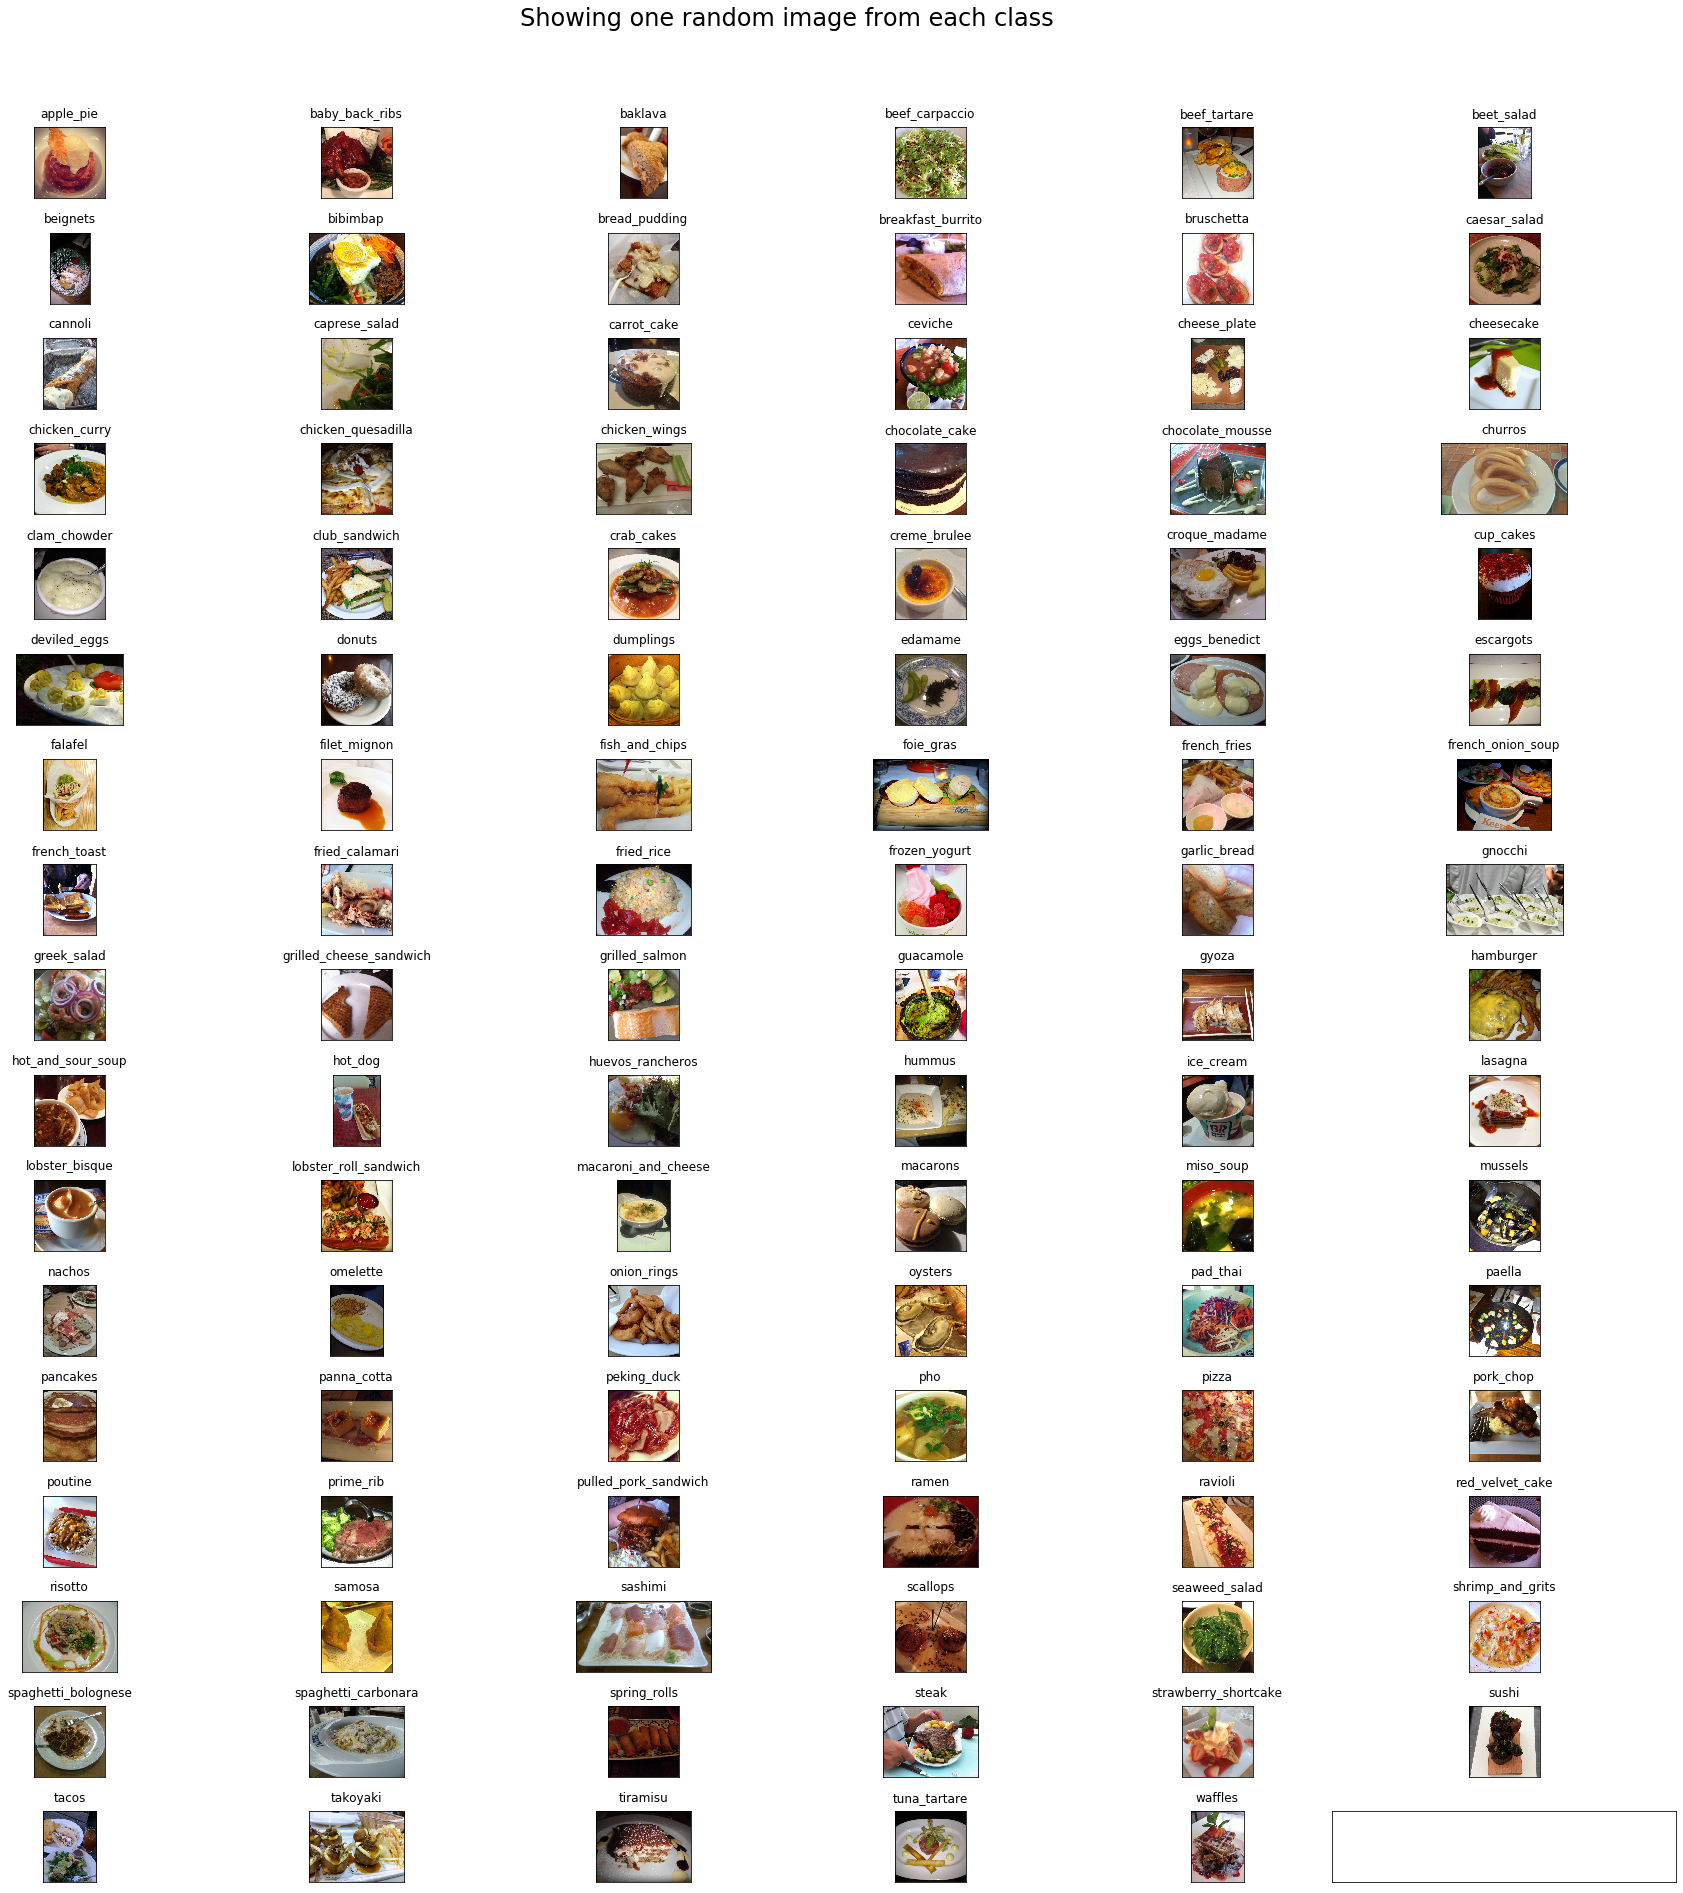

In [7]:
dataVisualize(17,6)

# Data Prepration

## Split data into train and test

In [0]:
def dataPrepare(filepath, src, dest):
  if os.path.exists(dest):
      print('Path already exists.\nDo you want to continue y/n (all data will be lost)')
      inp = input()
      if inp == 'y':
        print('Replacing data ...')
        rmtree(dest)
      else:
        print('Operation canceled')
        return

  classes_images = defaultdict(list)
  with open(filepath,'r') as txt:
    paths = [line.strip() for line in txt.readlines()]
    for p in paths:
      food = p.split('/')
      classes_images[food[0]].append(food[1] + '.jpg')
    
  for food in classes_images.keys():
    print('Copying images into ',food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print('All done')

### Create train data

In [0]:
print('Creating training data ...')
dataPrepare('food-101/meta/train.txt','food-101/images','train')

In [11]:
print('Total samples in train folder')
!find train -type d -or -type f -printf '.' | wc -c

Total samples in train folder
75750


### Create test data

In [0]:
print('Creating testing data ...')
dataPrepare('food-101/meta/test.txt','food-101/images','test')

In [13]:
print('Total samples in test folder')
!find test -type d -or -type f -printf '.' | wc -c

Total samples in test folder
25250


## Create subset of data with less classes for fast training/experimenting

In [0]:
def sortedFoods():
  data_dir = 'food-101/images/'
  foods_sorted = sorted(os.listdir(data_dir))
  return foods_sorted

In [0]:
foods_sorted = sortedFoods()

## Method for creating train_mini and test_mini data samples

In [0]:
def miniDataset(food_list, src, dest):
  if os.path.exists(dest):
      print('Path already exists.\nDo you want to continue y/n (all data will be lost)')
      inp = input()
      if inp == 'y':
        print('Replacing data ...')
        rmtree(dest)
      else:
        print('Operation canceled')
        return
  os.makedirs(dest)

  for food_item in food_list:
    print('Copying images into ',food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [74]:
food_list = [
             'apple_pie',
             'baby_back_ribs',
             'beef_carpaccio',
             'bread_pudding',
             'caesar_salad',
             'cannoli',
             'carrot_cake',
             'cheesecake',
             'chicken_curry',
             'chicken_wings',
             'chocolate_cake',
             'chocolate_mousse',
             'churros',
             'cup_cakes',
             'donuts',
             'dumplings',
             'falafel',
             'fish_and_chips',
             'french_fries',
             'french_toast',
             'fried_rice',
             'garlic_bread',
             'grilled_salmon',
             'guacamole',
             'hot_dog',
             'hot_and_sour_soup',
             'hummus',
             'hamburger',
             'ice_cream',
             'lasagna',
             'macaroni_and_cheese',
             'macarons',
             'nachos',
             'onion_rings',
             'oysters',
             'pancakes',
             'pork_chop',
             'poutine',
             'ramen',
             'ravioli',
             'risotto',
             'spaghetti_bolognese',
             'spaghetti_carbonara',
             'steak',
             'sushi',
             'tacos',
             'waffles',
             'pizza',
             'omelette'
]

src_train = 'train'
src_test = 'test'

dest_train = 'train_mini'
dest_test = 'test_mini'
leng = len(food_list)
leng

49

In [75]:
print('Creating mini train data folder')
miniDataset(food_list,src_train,dest_train)

print('Total number of samples in train_mini:')
!find train_mini -type d -or -type f -printf '.' | wc -c

Creating mini train data folder
Path already exists.
Do you want to continue y/n (all data will be lost)
y
Replacing data ...
Copying images into  apple_pie
Copying images into  baby_back_ribs
Copying images into  beef_carpaccio
Copying images into  bread_pudding
Copying images into  caesar_salad
Copying images into  cannoli
Copying images into  carrot_cake
Copying images into  cheesecake
Copying images into  chicken_curry
Copying images into  chicken_wings
Copying images into  chocolate_cake
Copying images into  chocolate_mousse
Copying images into  churros
Copying images into  cup_cakes
Copying images into  donuts
Copying images into  dumplings
Copying images into  falafel
Copying images into  fish_and_chips
Copying images into  french_fries
Copying images into  french_toast
Copying images into  fried_rice
Copying images into  garlic_bread
Copying images into  grilled_salmon
Copying images into  guacamole
Copying images into  hot_dog
Copying images into  hot_and_sour_soup
Copying ima

In [76]:
print('Creating mini test data folder')
miniDataset(food_list,src_test,dest_test)

print('Total number of samples in test_mini:')
!find test_mini -type d -or -type f -printf '.' | wc -c

Creating mini test data folder
Path already exists.
Do you want to continue y/n (all data will be lost)
y
Replacing data ...
Copying images into  apple_pie
Copying images into  baby_back_ribs
Copying images into  beef_carpaccio
Copying images into  bread_pudding
Copying images into  caesar_salad
Copying images into  cannoli
Copying images into  carrot_cake
Copying images into  cheesecake
Copying images into  chicken_curry
Copying images into  chicken_wings
Copying images into  chocolate_cake
Copying images into  chocolate_mousse
Copying images into  churros
Copying images into  cup_cakes
Copying images into  donuts
Copying images into  dumplings
Copying images into  falafel
Copying images into  fish_and_chips
Copying images into  french_fries
Copying images into  french_toast
Copying images into  fried_rice
Copying images into  garlic_bread
Copying images into  grilled_salmon
Copying images into  guacamole
Copying images into  hot_dog
Copying images into  hot_and_sour_soup
Copying imag

# Model Creation

## Tunning the **Inception pretrained model** for our dataset

Why:
*  Keras and other deep learning libraries provide pretrained models so that development is easier (these models might have been training for hours or days)
*  These models are deep neural networks with efficient architectures, the user does not need to concern himself with the defenition of the model
*  Using  this pretrained models we can use already learned weights and add a few layers on top of it to finetune the model to our specific data
*  This helps in faster convergance and saves time and computation when compared to models trainedd from scratch

### Step by step functions

In [0]:
def modelTune(n_classes,img_width,img_height,train_data_dir,validation_data_dir,nb_trai_samples,nb_validation_samples,batch_size):
  train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
  
  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
  
  validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
  return train_datagen,test_datagen,train_generator,validation_generator

#### Model Build

In [0]:
def modelBuild():
  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
model = modelBuild()

87916544/87910968 [==============================] - 1s 0us/step


#### Model Train/Fit and save

In [0]:
def modelTrain(model,ep,nb_trai_samples,nb_validation_samples,batch_size,train_generator,validation_generator):
  checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
  csv_logger = CSVLogger('history_3class.log')

  history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=ep,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])
  
  model.save('model_trained_class.hdf5')

## Putting it all together

In [0]:
class ImageClassificationNN():
  def __init__(self):
    K.clear_session()
    print('Model Session initiated')

  def modelTune(self,n_classes,img_width,img_height,train_data_dir,validation_data_dir,nb_train_samples,nb_validation_samples,batch_size):
    self.n_classes = n_classes
    self.nb_train_samples = nb_train_samples
    self.nb_validation_samples = nb_validation_samples
    self.batch_size = batch_size

    train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
    self.train_datagen = train_datagen
    self.test_datagen = test_datagen
    self.train_generator = train_generator
    self.validation_generator = validation_generator
    return train_datagen,test_datagen,train_generator,validation_generator

  def modelBuild(self,activation='softmax',loss='categorical_crossentropy', metrics=['accuracy'],units=101):
      inception = InceptionV3(weights='imagenet', include_top=False)
      x = inception.output
      x = GlobalAveragePooling2D()(x)
      x = Dense(128,activation='relu')(x)
      x = Dropout(0.2)(x)

      predictions = Dense(units,kernel_regularizer=regularizers.l2(0.005), activation=activation)(x)
      self.model = Model(inputs=inception.input, outputs=predictions)
      self.model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=loss, metrics=metrics)
      return self.model

  def modelTrain(self,epochs=30):
      checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
      csv_logger = CSVLogger('history_3class.log')

      history = self.model.fit(self.train_generator,
                        steps_per_epoch=self.nb_train_samples // batch_size,
                        validation_data=self.validation_generator,
                        validation_steps=self.nb_validation_samples // batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[csv_logger, checkpointer])
      
      self.model.save('model_trained_class.hdf5')
      return history, self.model

# Applying model

In [95]:
#we only have 3 classes in mini samples
img_classification = ImageClassificationNN()

Model Session initiated


In [0]:
n_classes = leng
img_width,img_height = 229,229
train_data_dir,validation_data_dir = 'train_mini','test_mini'
nb_train_samples,nb_validation_samples = 36750, 12250
batch_size = 256

In [97]:
train_datagen,test_datagen,train_generator,validation_generator = img_classification.modelTune(
    n_classes,
    img_width,img_height,
    train_data_dir,validation_data_dir,
    nb_train_samples,nb_validation_samples,
    batch_size
)

Found 36750 images belonging to 49 classes.
Found 12250 images belonging to 49 classes.


In [0]:
model = img_classification.modelBuild(units=49)

In [0]:
history, model = img_classification.modelTrain()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 47 steps
Epoch 1/30


# Visualize accuracy

In [52]:
class_map_3 = train_generator.class_indices
class_map_3

{'hamburger': 0, 'omelette': 1, 'pizza': 2}

In [0]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
  
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [54]:

plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

NameError: ignored

# Prediction

In [56]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('model_trained_class.hdf5',compile = False)

CPU times: user 3.39 s, sys: 126 ms, total: 3.52 s
Wall time: 3.37 s


In [0]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [60]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg
!wget -O hamburg.jpg https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FHamburger&psig=AOvVaw2Wp6h2o_vIGkgyRuSdS84-&ust=1583857252187000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCJClyKDmjegCFQAAAAAdAAAAABAD


Saving hamb.jfif to hamb.jfif
Saving omlett.jfif to omlett.jfif
Saving pizza.jfif to pizza.jfif


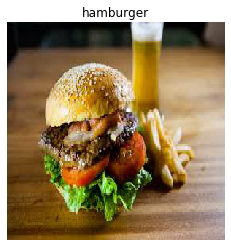

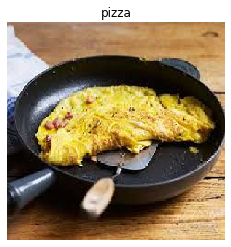

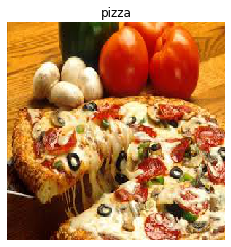

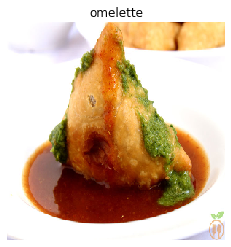

In [69]:
# Make a list of downloaded images and test the trained model
images = []
images.append('hamb.jfif')
images.append('omlett.jfif')
images.append('pizza.jfif')
images.append('samosa.jpg')
predict_class(model_best, images, True)